# Export Data for Web Application 

In [4]:
from cflp_function import cflp, plot_result, store_data_to_pickle, load_data_from_pickle, find_farm_not_in_solution_plant_in_solution, get_arc
from pulp import *
import pandas as pd
import numpy as np
import pydeck as pdk
import geopandas as gpd
import os
# import rasterio
# from rasterio.plot import reshape_as_image
from shapely.geometry import mapping

import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# version_number = 6

### Load files and create parameters
* q_j max capacity of each j 
* f_j fixed cost of establishing each j
* set F set of farm locations
* set P set of potential digester locations
* C_ij transportation matrix 
* p_i 
* alpha
* mu

In [6]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm/farm_cluster_mock_5.csv')
potential_digester_location.head()

x          y  count
0  6.870686  52.215190     25
1  6.554937  52.254895     25
2  6.730518  52.252885     42
3  6.914234  52.387401     18
4  6.664105  52.392622     32

In [7]:
# potential_digester_location = gpd.read_file(r'./raster/suitable_polygons_complete_gdf.shp')
# potential_digester_location.head()

In [8]:
# Define the capacities of digester
small_digester_capacity = 78480
medium_digester_capacity = 150560  # in tonne/yr
# large_digester_capacity = 200000  # in tonne/yr

# Define the costs of digester 
small_digester_cost = 209249
medium_digester_cost = 252616   # in euro CAPEX
# large_digester_cost = 12000000    # in euro CAPEX

In [9]:
potential_digester_location = potential_digester_location.drop(['count'], axis=1) # drop unnecessary column

In [10]:
# # Create mock digester capacity data 
potential_digester_location['capacity'] = [medium_digester_capacity, medium_digester_capacity, small_digester_capacity, medium_digester_capacity, small_digester_capacity]
# potential_digester_location['capacity'] = small_digester_capacity
# # Create mock digester cost data (f_j)
potential_digester_location['cost'] = [medium_digester_cost, medium_digester_cost, small_digester_capacity, medium_digester_cost, small_digester_capacity]
# potential_digester_location['cost'] = small_digester_cost

## !!! Be careful here, max_capacity and fixed_cost should have keys that are the labels of Plant not the index, otherwise the model doesn't run!!!

In [11]:
# (q_j)
max_capacity = potential_digester_location['capacity'].to_dict()    # Max_Supply = {'Fac-1' : 500, 'Fac-2' : 500, 'Fac-3' : 500}
# max_capacity = potential_digester_location.set_index('Label')['capacity'].to_dict()
# (f_j)
fixed_cost = potential_digester_location['cost'].to_dict()  # fixed_cost = {'Fac-1' : 1000, 'Fac-2' : 1000, 'Fac-3' : 1000 }
# fixed_cost = potential_digester_location.set_index('Label')['cost'].to_dict()

In [13]:
farm = pd.read_csv(r"./farm/farm_mock.csv")
farm.head()

Unnamed: 0         x          y IND_OBJ_NA  manure_t  biogas_potential_m3
0           0  6.765843  52.314139     507920      2454             957060.0
1           1  6.837249  52.425084     507950      9827            3832530.0
2           2  6.859361  52.386225     507953      8660            3377400.0
3           3  6.753483  52.434382     507962      2913            1136070.0
4           4  6.484077  52.243620     507964      6488            2530320.0

In [ ]:
# farm = gpd.read_file(r"./farm_new.shp")
# farm.head()

In [14]:
# Lists (sets / Array) of Customers and Facilities
Farm = farm.index.tolist()  # set F
# Plant = potential_digester_location.Label.tolist() # set P
Plant = potential_digester_location.index.tolist()

In [15]:
# (p_i)
manure_production = farm['manure_t'].to_dict()  

# Define the total manure production by all farms (alpha)
total_manure = sum(manure_production[i] for i in Farm)

In [16]:
folder_path = 'app_data'

In [17]:
# Export files

# List
store_data_to_pickle(Farm, folder_path, 'Farm_test.pickle') # set F
store_data_to_pickle(Plant, folder_path, 'Plant_test.pickle') # set P

# Dictionary 
store_data_to_pickle(manure_production, folder_path, 'manure_production_test.pickle') # p_i 
store_data_to_pickle(max_capacity, folder_path, 'max_capacity_test.pickle') # q_j
store_data_to_pickle(fixed_cost, folder_path, 'fixed_cost_test.pickle') # f_j

# C_ij 

# Float
store_data_to_pickle(total_manure, folder_path, 'total_manure_test.pickle') # alpha

In [9]:
Farm = load_data_from_pickle(folder_path, 'Farm_test.pickle')
        # set P     set of potential digester locations
Plant = load_data_from_pickle(folder_path, 'Plant_test.pickle')
    # Dictionary 
        # p_i       manure production of each i
manure_production = load_data_from_pickle(folder_path, 'manure_production_test.pickle')
        # q_j       max capacity of each j 
max_capacity = load_data_from_pickle(folder_path, 'max_capacity_test.pickle')
        # f_j       fixed cost of establishing each j
fixed_cost = load_data_from_pickle(folder_path, 'fixed_cost_test.pickle')        
        # C_ij      transportation matrix 
transport_cost = load_data_from_pickle(folder_path, 'transportation_cost_test.pickle')
    # Float
        # alpha     total manure production
total_manure = load_data_from_pickle(folder_path, 'total_manure_test.pickle')
    # Float defined here
        # mu        manure utilization target 

## CFLP Model
* cflp: the cflp model
* find_farm_not_in_solution_plant_in_solution: disaggregating outputs for result visualization 
* plot_result: plot optimal solution (calls the previous function)

In [31]:
# Define manure use goal (mu)
target = 0.5

In [30]:
def cflp(Plant, Farm, fixed_cost, transport_cost, manure_production, max_capacity, target, total_manure):
    """
    Input
    * Plant: list (sets/array) of facility indices
    * Farm: list (sets/array) of customer indices
    * fixed_cost: dictionary of fixed cost of each Plant - {Plant:fixed cost}
    * transport_cost: nested dictionary of shortest paths (OD matrix) from all Farm to all Plant - {Plant:{Farm:distance}}
    * manure_production: quantity of manure in each Farm - {Farm:manure quantity}
    * max_capacity: maximum capacity of each Plant - {Plant:max capacity}
    * target: float of manure use goal defined as policy
    * total_manure: total manure produced by all Farm
    """

    # Setting the Problem
    prob = LpProblem("Capacitated_Facility_Location_Problem", LpMinimize)

    # Defining our Decision Variables
    use_plant = LpVariable.dicts("Plant", Plant, 0, 1, LpBinary) 
    ser_farm = LpVariable.dicts("Farm_Plant", [(i, j) for i in Farm for j in Plant], 0, 1, LpBinary) 

    # Objective Function
    prob += lpSum(fixed_cost[j]*use_plant[j] for j in Plant) + lpSum(transport_cost[j][i]*ser_farm[(i,j)] for j in Plant for i in Farm)

    # Costraints
    for i in Farm:
        prob += lpSum(ser_farm[(i, j)] for j in Plant) <= 1 # Very strange, the model becomes infeasible  if it's == 1, maybe because now the constraint has relaxed and not all farms need to be assigned to facility, which will be the case if ==1

    # The capacity constraint here it differnt than the one in paper, but i think it does the work still
    for j in Plant:
        prob += lpSum(manure_production[i] * ser_farm[(i,j)] for i in Farm) <= max_capacity[j]*use_plant[j]

    # Not really sure what this constraint does, I think it makes sure a farm can only be assigned to a facility given it's open, hence the value of xij is smaller or equal to yj 
    for i in Farm:
        for j in Plant:
            prob += ser_farm[(i,j)] <= use_plant[j]

    # Add a constraint to ensure at least x% of total manure production is sent to plants
    prob += lpSum(manure_production[i] * ser_farm[(i, j)] for i in Farm for j in Plant) >= target * total_manure

    # Solve 
    prob.solve()
    print("Solution Status = ", LpStatus[prob.status])
    
    return 

In [17]:
solver = pywraplp.Solver.CreateSolver('GLOP')

In [19]:
use_plant = {j: solver.BoolVar(f'use_plant_{j}') for j in Plant}
ser_farm = {(i, j): solver.BoolVar(f'ser_farm_{i}_{j}') for i in Farm for j in Plant}

In [25]:
# Objective Function
objective = solver.Objective()
objective.SetMinimization()

# Linear expression for the total cost
total_cost_expr = sum(fixed_cost[j] * use_plant[j] for j in Plant) + \
    sum(transport_cost[j][i] * ser_farm[(i, j)] for j in Plant for i in Farm)

In [27]:
# Add the expression to the objective function
objective.SetCoefficient(total_cost_expr, 1)

# Constraints (unchanged)
for i in Farm:
    solver.Add(sum(ser_farm[(i, j)] for j in Plant) <= 1)

for j in Plant:
    solver.Add(sum(manure_production[i] * ser_farm[(i, j)] for i in Farm) <= max_capacity[j] * use_plant[j])

for i in Farm:
    for j in Plant:
        solver.Add(ser_farm[(i, j)] <= use_plant[j])

SystemError: <built-in function Objective_SetCoefficient> returned NULL without setting an exception

In [ ]:
# def or_tools_cflp(Plant, Farm, fixed_cost, transport_cost, manure_production, max_capacity, target, total_manure):
#     # Create a CP-SAT model
#     model = cp_model.CpModel()

#     # Decision variables
#     open_facility = {j: model.NewBoolVar(f'Open_Facility_{j}') for j in Plant}
#     assign_farm_to_facility = {(i, j): model.NewBoolVar(f'Assign_Farm_{i}_to_Facility_{j}') for i in Farm for j in Plant}

#     # Objective function
#     total_cost = model.NewIntVar(0, sum(fixed_cost.values()) + sum(max_capacity.values()) * max(transport_cost[j][i] for i in Farm for j in Plant), 'Total_Cost')
#     model.Add(total_cost == sum(fixed_cost[j] * open_facility[j] + transport_cost[j][i] * assign_farm_to_facility[i, j] for i in Farm for j in Plant))

#     # Constraints
#     for i in Farm:
#         model.Add(sum(assign_farm_to_facility[i, j] for j in Plant) == 1)

#     for j in Plant:
#         model.Add(sum(manure_production[i] * assign_farm_to_facility[i, j] for i in Farm) <= max_capacity[j] * open_facility[j])

#     model.Add(sum(manure_production[i] * assign_farm_to_facility[i, j] for i in Farm for j in Plant) >= target * total_manure)

#     # Solve the model
#     solver = cp_model.CpSolver()
#     status = solver.Solve(model)

#     # Print or analyze the results
#     if status == cp_model.OPTIMAL:
#         print("Optimal Solution Found:")
#         print("Open Facilities:", [j for j in Plant if solver.Value(open_facility[j]) == 1])
#         print("Facility Assignments:", {i: j for i in Farm for j in Plant if solver.Value(assign_farm_to_facility[i, j]) == 1})
#         print("Total Cost:", solver.ObjectiveValue())
#     else:
#         print("No Optimal Solution Found.")

# # Example usage
# Plant = {1, 2, 3}
# Farm = {4, 5, 6}
# fixed_cost = {1: 10, 2: 15, 3: 12}
# transport_cost = {1: {4: 5, 5: 8, 6: 10}, 2: {4: 7, 5: 6, 6: 9}, 3: {4: 8, 5: 7, 6: 6}}
# manure_production = {4: 3, 5: 4, 6: 5}
# max_capacity = {1: 6, 2: 8, 3: 7}
# target = 0.5
# total_manure = 12

# or_tools_cflp(Plant, Farm, fixed_cost, transport_cost, manure_production, max_capacity, target, total_manure)


In [32]:
total_cost, total_fixed_cost, total_transport_cost, assignment_decision, use_plant_index = cflp(Plant, Farm, fixed_cost, transport_cost, manure_production, max_capacity, target, total_manure)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/7b0857ecb93d409581b1c878d9de7b9c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/7b0857ecb93d409581b1c878d9de7b9c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 863 COLUMNS
At line 6564 RHS
At line 7423 BOUNDS
At line 8139 ENDATA
Problem MODEL has 858 rows, 715 columns and 3555 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 485275 - 0.00 seconds
Cgl0008I 142 inequality constraints converted to equality constraints
Cgl0004I processed model has 858 rows, 857 columns (857 integer (857 of which binary)) and 3697 elements
Cbc0038I Initial state - 55 integers unsatisfied sum - 15.5239
Cbc

TypeError: cannot unpack non-iterable NoneType object

In [18]:
# # Check if the opened plants are under-utilized
# total_sum_list = [sum(farm.loc[i, 'manure_t'] for i in value) for value in assignment_decision.values()]

# potential_digester_location['allocated_manure'] = total_sum_list

# # Find the percentage of plant's capacity that is utilized
# potential_digester_location['underutilized'] = 0
# mask = potential_digester_location['allocated_manure'] > 0
# potential_digester_location.loc[mask, 'underutilized'] = (1 - (potential_digester_location.loc[mask, 'allocated_manure'] / potential_digester_location.loc[mask, 'capacity'])) * 100
# potential_digester_location

In [10]:
filename = f"./outputs/cflp_v{6}_{int(target*100)}%manure.png"  # You can choose the file extension (e.g., .png, .jpg, .pdf)

There are no duplicates in the list.


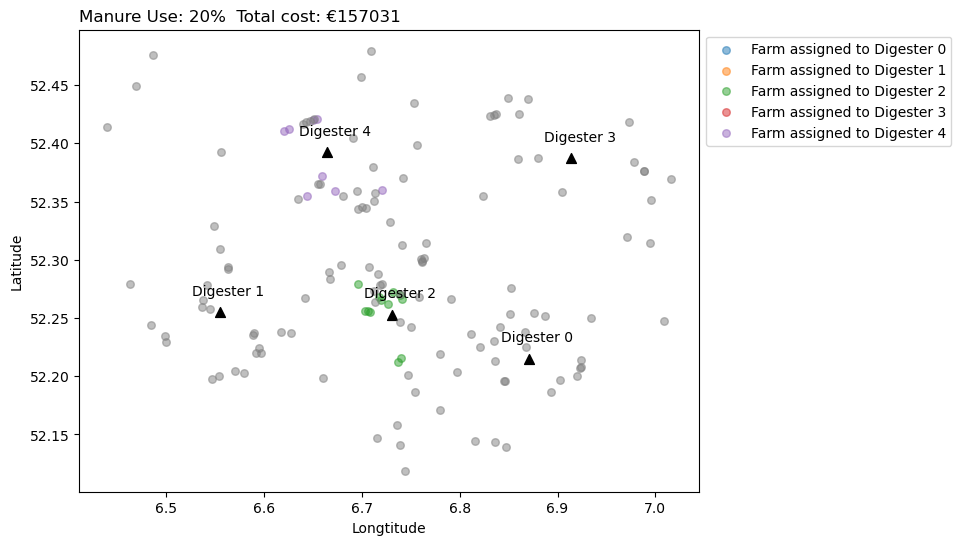

In [11]:
plot_result(Plant, potential_digester_location, assignment_decision, farm, Farm, use_plant_index, target, total_cost, filename, save_fig=False)

In [16]:
for key, value in assignment_decision.items():
    print(f"{key}: {value}")

0: []
1: []
2: [24, 40, 41, 48, 76, 77, 92, 123, 124, 125, 133, 137]
3: []
4: [66, 69, 70, 111, 113, 114, 121, 128]


## Plot with PyDeck

In [43]:
os.environ["MAPBOX_API_KEY"]="sk.eyJ1Ijoid2VueXVjaGVuIiwiYSI6ImNscDZxZ2hpZzF0ejYyaXBicWs0YWZzb2kifQ.ReihW6LnhBUycKmcX_OIYQ"
MAPBOX_API_KEY = os.environ["MAPBOX_API_KEY"]

In [19]:
import random
# Create a color mapping for digesters 
color_mapping = {label: [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)] for label in assignment_decision.keys()}

In [21]:
digester_df, assigned_farms_df, unassigned_farms_df = get_plot_variables(assignment_decision, potential_digester_location, farm, color_mapping)

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_57414/3071834205.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assigned_farms_df['color'] = assigned_farms_df.index.map({index: color_mapping[digester] for digester, indices in assignment_decision.items() for index in indices})


In [22]:
# Create a Pydeck layer for digesters
digesters_layer = pdk.Layer(
    type='ScatterplotLayer',
    data=digester_df,
    get_position=['x', 'y'],
    get_radius=1000,
    get_fill_color='color',
    pickable=True,
    auto_highlight=True
)

# Create a Pydeck layer for assigned farms
assigned_farms_layer = pdk.Layer(
    type='ScatterplotLayer',
    data=assigned_farms_df,
    get_position=['x', 'y'],
    get_radius=500,
    get_fill_color='color',
    pickable=True,
    auto_highlight=True
)

# Create a Pydeck layer for unassigned farms
unassigned_farms_layer = pdk.Layer(
    type='ScatterplotLayer',
    data=unassigned_farms_df,
    get_position=['x', 'y'],
    get_radius=500,
    get_fill_color=[128, 128, 128],
    pickable=True,
    auto_highlight=True
)

# Create a Pydeck deck
deck = pdk.Deck(
    layers=[digesters_layer, assigned_farms_layer, unassigned_farms_layer],
    initial_view_state=pdk.ViewState(
        latitude=potential_digester_location['y'].mean(),
        longitude=potential_digester_location['x'].mean(),
        zoom=8,
        pitch=0
    )
)

# Show the Pydeck Deck
deck.to_html("deck_trial_2.html")

In [44]:
# # Import Mapbox API Key from environment
MAPBOX_API_KEY = os.environ["MAPBOX_API_KEY"]
 
# # AWS Open Data Terrain Tiles
# TERRAIN_IMAGE = "https://s3.amazonaws.com/elevation-tiles-prod/terrarium/{z}/{x}/{y}.png"
 
# # Define how to parse elevation tiles
# ELEVATION_DECODER = {"rScaler": 256, "gScaler": 1, "bScaler": 1 / 256, "offset": -32768}
 
# SURFACE_IMAGE = f"https://api.mapbox.com/v4/mapbox.satellite/{{z}}/{{x}}/{{y}}@2x.png?access_token={MAPBOX_API_KEY}"
 
# terrain_layer = pdk.Layer(
#     "TerrainLayer", elevation_decoder=ELEVATION_DECODER, texture=SURFACE_IMAGE, elevation_data=TERRAIN_IMAGE
# )
 
# view_state = pdk.ViewState(latitude=46.24, longitude=-122.18, zoom=11.5, bearing=140, pitch=60)
 
# r = pdk.Deck(terrain_layer, initial_view_state=view_state)

# # Show the Pydeck Deck
# r.to_html("terrain_layer.html")

In [14]:
arc_layer_df = get_arc(assignment_decision, potential_digester_location, farm)

In [18]:
import leafmap
# raster_path = '/Users/wenyuc/Desktop/UT/data/raster/fuzzy_4326.tif'

raster_path = '/Users/wenyuc/Desktop/UT/data/raster/fuzzy_complete_3857.tif'

In [19]:
m = leafmap.Map()
m.add_raster(raster_path, cmap="viridis", layer_name="Raster Layer")
m

In [126]:
raster_file = '/Users/wenyuc/Desktop/UT/data/raster/fuzzy_and_complete_1_4326.tif'


#'/Users/wenyuc/Desktop/UT/data/raster/fuzzy_4326.tif'

# with rasterio.open(raster_file) as src:
#     band1 = src.read(1)
#     print('Band1 has shape', band1.shape)
#     height = band1.shape[0]
#     width = band1.shape[1]
#     bbox = src.bounds
#     cols, rows = np.meshgrid(np.arange(width), np.arange(height))
#     xs, ys = rasterio.transform.xy(src.transform, rows, cols)
#     lons= np.array(xs)
#     lats = np.array(ys)
#     print('lons shape', lons.shape)

Band1 has shape (4356, 5057)
lons shape (4356, 5057)


In [ ]:
def raster_to_df(raster_file):
    with rasterio.open(raster_file) as src:
        band1 = src.read(1)
        # bbox = src.bounds
        cols, rows = np.meshgrid(np.arange(band1.shape[1]), np.arange(band1.shape[0])) #band1.shape[0]= height ; band1.shape[1] = width
        xs, ys = rasterio.transform.xy(src.transform, rows, cols)
        lons= np.array(xs)
        lats = np.array(ys)
    # Flatten the arrays and create a DataFrame
    df = pd.DataFrame({
        'Latitude': lats.flatten(),
        'Longitude': lons.flatten(),
        'Value': band1.flatten()})
    # Filter out no-data values
    df = df[df['Value'] != src.nodatavals[0]]

    return df

def get_hex_layer(raster_df, hex_size):
    hex_col = 'hex'+str(hex_size)

    # find hexs containing the points
    raster_df[hex_col] = raster_df.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, hex_size),1)
    df_hex = raster_df.groupby(hex_col)['Value'].mean().to_frame('Value').reset_index()

    #find center of hex for visualization
    df_hex['lat'] = df_hex[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    df_hex['lng'] = df_hex[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

    return df_hex

In [136]:
# # Define a layer to display on a map
# layer = pdk.Layer(
#     "ScreenGridLayer",
#     df,
#     pickable=False,
#     opacity=0.7,
#     cell_size_pixels=50,
#     color_range=[
#         [0, 25, 0, 25],
#         [0, 85, 0, 85],
#         [0, 127, 0, 127],
#         [0, 170, 0, 170],
#         [0, 190, 0, 190],
#         [0, 255, 0, 255],
#     ],
#     get_position=["Longitude", "Latitude"],
#     get_weight="Value",
# )
# # Set the viewport location
# view_state = pdk.ViewState(longitude=df['Longitude'].mean(), latitude=df['Latitude'].mean(), zoom=10, bearing=0, pitch=0)

# # Render
# r = pdk.Deck(layers=[layer], initial_view_state=view_state)
# r.to_html("screengrid_layer.html")

In [135]:
# H3_HEX_DATA = "https://raw.githubusercontent.com/visgl/deck.gl-data/master/website/sf.h3cells.json"

# df = pd.read_json(H3_HEX_DATA)

# color_scale = [
#     [0, 0, 255],  # Blue
#     [255, 255, 255],  # White
#     [255, 0, 0],  # Red
# ]

# from matplotlib.colors import to_rgba_array
# # Create a Viridis color map using matplotlib
# viridis_cmap = plt.get_cmap("viridis")
# color_values = to_rgba_array(viridis_cmap(df_dem[]]))

color_scale = [
    [0, 255, 0, 255],  # RGB color for value 0 (green)
    [255, 0, 0, 255]   # RGB color for value 1 (red)
]

# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    df_dem,
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    opacity=0.7,
    get_hexagon="hex7",
    get_fill_color ='[255 * Value, 255 * (1 - Value), 0, 255]', 
    get_line_color=[255, 255, 255],
    line_width_min_pixels=2)

# Set the viewport location
# view_state = pdk.ViewState(latitude=37.7749295, longitude=-122.4194155, zoom=14, bearing=0, pitch=30)
view_state = pdk.ViewState(longitude=df_dem['lng'].mean(), latitude=df_dem['lat'].mean(), zoom=10, bearing=0, pitch=0)


# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip={"text": "Count: {Value}"})
r.to_html("h3_hexagon_layer.html")

([], [])

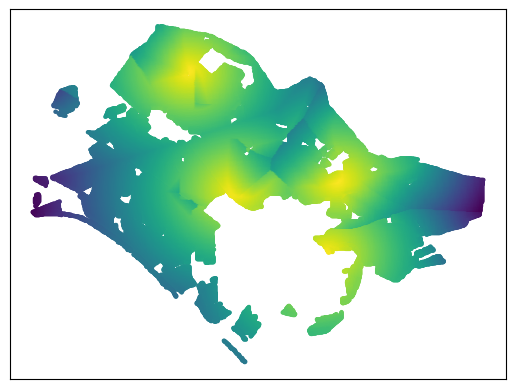

In [33]:
plt.scatter(x=df.Longitude, y=df.Latitude, c=df.Value, edgecolors='none', cmap='viridis', marker='.', alpha=1)
plt.xticks([], []); plt.yticks([], [])

In [128]:
import h3

APERTURE_SIZE = 7
hex_col = 'hex'+str(APERTURE_SIZE)

In [129]:
# find hexs containing the points
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, APERTURE_SIZE),1)

In [130]:
df_dem = df.groupby(hex_col)['Value'].mean().to_frame('Value').reset_index()

In [131]:
#find center of hex for visualization
df_dem['lat'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df_dem['lng'] = df_dem[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

([], [])

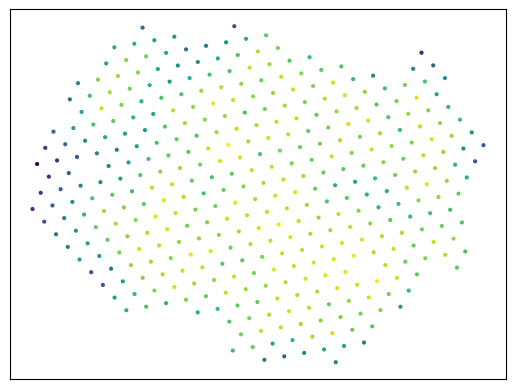

In [132]:
plt.scatter(df_dem.lng, df_dem.lat, c=df_dem.Value, edgecolors='none', cmap='viridis', marker='.', alpha=1)
plt.xticks([], []); plt.yticks([], [])

In [134]:
df_dem.to_csv('./df_hex_7.csv')

In [155]:
df = pd.read_csv('./df_hex_9.csv')

In [156]:
df = df.drop('Unnamed: 0', axis=1)

In [157]:
df['suitability'] = (df['Value']*100).round(1)

In [158]:
df

hex9     Value        lat       lng  suitability
0      891f1600003ffff  0.599844  52.340083  7.038925         60.0
1      891f160000bffff  0.631382  52.337392  7.036908         63.1
2      891f160000fffff  0.591946  52.337959  7.041762         59.2
3      891f1600013ffff  0.633506  52.342208  7.036088         63.4
4      891f1600017ffff  0.589545  52.342775  7.040941         59.0
...                ...       ...        ...       ...          ...
14933  891f16d5ec7ffff  0.835780  52.468018  6.506818         83.6
14934  891f16d5ecbffff  0.853523  52.464737  6.499983         85.4
14935  891f16d5ecfffff  0.843583  52.465326  6.504826         84.4
14936  891f16d5ed3ffff  0.814119  52.469533  6.499124         81.4
14937  891f16d5ed7ffff  0.796489  52.470121  6.503967         79.6

[14938 rows x 5 columns]

In [159]:
df.to_csv('./df_hex_9.csv')

In [187]:
polygons = gpd.read_file(r'./raster/suitable_polygons_complete_gdf_50.shp')
polygons.head()

Label                                           geometry
0      1  MULTIPOLYGON (((740409.152 6878314.958, 741009...
1      2  POLYGON ((775409.152 6870914.958, 775459.152 6...
2      3  MULTIPOLYGON (((741009.152 6869414.958, 741209...
3      4  MULTIPOLYGON (((737509.152 6864714.958, 738409...
4      5  MULTIPOLYGON (((728959.152 6860714.958, 729059...

In [188]:
polygons['area'] = polygons['geometry'].area

In [190]:
polygons = polygons.to_crs('EPSG:4326')

In [191]:
polygons['coordinates'] = polygons['geometry'].apply(lambda geom: mapping(geom)['coordinates'][0])

In [198]:
polygons.drop('coordinates', axis=1).to_file('./suitable_polygon_plot.shp')

In [195]:
polygons

Label                                           geometry       area  \
0       1  MULTIPOLYGON (((6.65121 52.43035, 6.65660 52.4...  7702500.0   
1       2  POLYGON ((6.96562 52.38980, 6.96607 52.38980, ...    20000.0   
2       3  MULTIPOLYGON (((6.65660 52.38157, 6.65840 52.3...  2720000.0   
3       4  MULTIPOLYGON (((6.62516 52.35579, 6.63324 52.3...  2570000.0   
4       5  MULTIPOLYGON (((6.54835 52.33384, 6.54925 52.3...  1230000.0   
5       6  POLYGON ((6.76754 52.30337, 6.76979 52.30337, ...    32500.0   
6       7  POLYGON ((6.67142 52.30062, 6.67187 52.30062, ...     2500.0   
7       8  POLYGON ((6.65660 52.29787, 6.65750 52.29787, ...    25000.0   
8       9  POLYGON ((6.54880 52.29595, 6.55015 52.29595, ...    65000.0   
9      10  POLYGON ((6.56317 52.29265, 6.56452 52.29265, ...   107500.0   
10     11  POLYGON ((6.67142 52.27782, 6.67277 52.27782, ...   105000.0   
11     12  POLYGON ((6.66019 52.27507, 6.66109 52.27507, ...     5000.0   
12     13  POLYGON ((6.74284 52.27150, 6.74374 52.27150, ...    12500.0   
13     14  POLYGON ((6.74149 52.26930, 6.74194 52.26930, ...     2500.0   
14     15  POLYGON ((6.76574 52.26930, 6.76619 52.26930, ...     7500.0   
15     16  POLYGON ((6.71499 52.26297, 6.71634 52.26297, ...    57500.0   
16     17  POLYGON ((6.76170 52.26215, 6.76260 52.26215, ...     5000.0   
17     18  POLYGON ((6.54835 52.25665, 6.54880 52.25665, ...     2500.0   
18     19  POLYGON ((6.71723 52.24785, 6.71768 52.24785, ...     2500.0   
19     20  POLYGON ((6.88657 52.24758, 6.88702 52.24758, ...    15000.0   
20     21  POLYGON ((6.86276 52.24318, 6.86366 52.24318, ...    22500.0   
21     22  POLYGON ((6.99886 52.24125, 6.99931 52.24125, ...     2500.0   
22     23  POLYGON ((6.57485 52.23217, 6.57575 52.23217, ...   240000.0   
23     24  MULTIPOLYGON (((6.60090 52.22585, 6.60180 52.2...  1395000.0   
24     25  MULTIPOLYGON (((6.75272 52.22117, 6.75317 52.2...  1925000.0   
25     26  POLYGON ((6.77428 52.17795, 6.77473 52.17795, ...     2500.0   

                                          coordinates  
0   (((6.651208575654683, 52.430347346396964), (6....  
1   ((6.965618925096515, 52.389797007579986), (6.9...  
2   (((6.6565984673594, 52.38157279965013), (6.658...  
3   (((6.625157432415216, 52.35579369258654), (6.6...  
4   (((6.548351475622997, 52.333842175516395), (6....  
5   ((6.767540404948161, 52.3033663907504), (6.769...  
6   ((6.671420669547372, 52.30061979394294), (6.67...  
7   ((6.6565984673594, 52.29787302676774), (6.6574...  
8   ((6.548800633265056, 52.29595018837402), (6.55...  
9   ((6.563173677810969, 52.29265369975651), (6.56...  
10  ((6.671420669547372, 52.277816464698695), (6.6...  
11  ((6.660191728495877, 52.27506828330716), (6.66...  
12  ((6.742836734634873, 52.27149539273868), (6.74...  
13  ((6.741489261708694, 52.26929654770424), (6.74...  
14  ((6.765743774379921, 52.26929654770424), (6.76...  
15  ((6.714988960827168, 52.26297426068906), (6.71...  
16  ((6.761701355601383, 52.26214954809164), (6.76...  
17  ((6.548351475622997, 52.25665107212079), (6.54...  
18  ((6.717234749037467, 52.24785209252867), (6.71...  
19  ((6.886567180093997, 52.24757709629301), (6.88...  
20  ((6.86276182506483, 52.243176924708244), (6.86...  
21  ((6.998856590608937, 52.24125171242353), (6.99...  
22  ((6.574851776504523, 52.23217458659687), (6.57...  
23  (((6.600902919743989, 52.22584700712118), (6.6...  
24  (((6.752718202760188, 52.22116952091286), (6.7...  
25  ((6.774277769579057, 52.177948270110406), (6.7...

In [192]:
# Set up the Pydeck PolygonLayer
layer = pdk.Layer(
    "PolygonLayer",
    data=polygons,
    get_polygon='coordinates',
    get_fill_color=[255, 0, 0, 150],  # Red color with 150 transparency
    get_line_color=[255, 255, 255],
    get_line_width=2,
    pickable=True,
)

# Set up the Pydeck Deck
view_state = pdk.ViewState(
    latitude=potential_digester_location['y'].mean(),
    longitude=potential_digester_location['x'].mean(),
    zoom=8,
    bearing=0,
)

deck = pdk.Deck(
    initial_view_state=view_state,
    layers=[layer],
)

# Show the map
deck.to_html("polygon.html")


In [171]:
import math 
# Load in the JSON data
DATA_URL = "https://raw.githubusercontent.com/visgl/deck.gl-data/master/examples/geojson/vancouver-blocks.json"
json = pd.read_json(DATA_URL)
df = pd.DataFrame()

# Custom color scale
COLOR_RANGE = [
    [65, 182, 196],
    [127, 205, 187],
    [199, 233, 180],
    [237, 248, 177],
    [255, 255, 204],
    [255, 237, 160],
    [254, 217, 118],
    [254, 178, 76],
    [253, 141, 60],
    [252, 78, 42],
    [227, 26, 28],
    [189, 0, 38],
    [128, 0, 38],
]

BREAKS = [-0.6, -0.45, -0.3, -0.15, 0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2]


def color_scale(val):
    for i, b in enumerate(BREAKS):
        if val < b:
            return COLOR_RANGE[i]
    return COLOR_RANGE[i]


def calculate_elevation(val):
    return math.sqrt(val) * 10


# Parse the geometry out in Pandas
df["coordinates"] = json["features"].apply(lambda row: row["geometry"]["coordinates"])
df["valuePerSqm"] = json["features"].apply(lambda row: row["properties"]["valuePerSqm"])
df["growth"] = json["features"].apply(lambda row: row["properties"]["growth"])
df["elevation"] = json["features"].apply(lambda row: calculate_elevation(row["properties"]["valuePerSqm"]))
df["fill_color"] = json["features"].apply(lambda row: color_scale(row["properties"]["growth"]))

# Add sunlight shadow to the polygons
sunlight = {
    "@@type": "_SunLight",
    "timestamp": 1564696800000,  # Date.UTC(2019, 7, 1, 22),
    "color": [255, 255, 255],
    "intensity": 1.0,
    "_shadow": True,
}

ambient_light = {"@@type": "AmbientLight", "color": [255, 255, 255], "intensity": 1.0}

lighting_effect = {
    "@@type": "LightingEffect",
    "shadowColor": [0, 0, 0, 0.5],
    "ambientLight": ambient_light,
    "directionalLights": [sunlight],
}

view_state = pdk.ViewState(
    **{"latitude": 49.254, "longitude": -123.13, "zoom": 11, "maxZoom": 16, "pitch": 45, "bearing": 0}
)

LAND_COVER = [[[-123.0, 49.196], [-123.0, 49.324], [-123.306, 49.324], [-123.306, 49.196]]]

polygon_layer = pdk.Layer(
    "PolygonLayer",
    LAND_COVER,
    stroked=False,
    # processes the data as a flat longitude-latitude pair
    get_polygon="-",
    get_fill_color=[0, 0, 0, 20],
)

polygon_layer = pdk.Layer(
    "PolygonLayer",
    df,
    id="geojson",
    opacity=0.8,
    stroked=False,
    get_polygon="coordinates",
    filled=True,
    extruded=True,
    wireframe=True,
    get_elevation="elevation",
    get_fill_color="fill_color",
    get_line_color=[255, 255, 255],
    auto_highlight=True,
    pickable=True,
)

tooltip = {"html": "<b>Value per Square Meter:</b> {valuePerSqm} <br /><b>Growth rate:</b> {growth}"}

r = pdk.Deck(
    polygon_layer,
    initial_view_state=view_state,
    effects=[lighting_effect],
    map_style=pdk.map_styles.LIGHT,
    tooltip=tooltip,
)
r.to_html("polygon_layer.html")